In [1]:
%cd ../
%pip install -e .
%cd tutorials

c:\Users\pmamalet\Documents\Stage\POSEIDON
Obtaining file:///C:/Users/pmamalet/Documents/Stage/POSEIDON
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/Pruneeuh/AutoRoot to c:\users\pmamalet\appdata\local\temp\pip-install-ogts4ibc\autoroot_8882881c2e6b4a988cb7da6929d60918
  Resolved https://github.com/Pruneeuh/AutoRoot to commit ff8f86e72a049306abb809929cf9e1038262d000
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  

  Running command git clone --filter=blob:none --quiet https://github.com/Pruneeuh/AutoRoot 'C:\Users\pmamalet\AppData\Local\Temp\pip-install-ogts4ibc\autoroot_8882881c2e6b4a988cb7da6929d60918'

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

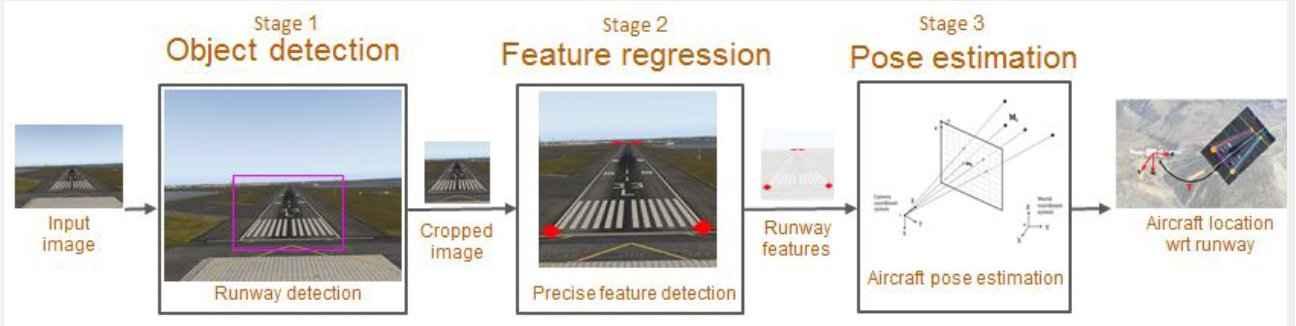

### 1. Import of the corners of the runway

Points 2D:
 tensor([[[485., 454.],
         [500., 454.],
         [438., 529.],
         [590., 526.]]], dtype=torch.float64)


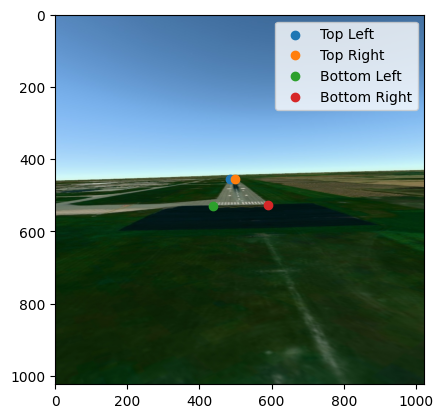

In [2]:
img = mpimg.imread("data/LARD_example.jpg")
plt.imshow(img)

df = pd.read_csv("data/extract_labeling_Bing.csv", delimiter=";")
dic = df.to_dict(orient="records")[0]

TL = [dic["x_TL"], dic["y_TL"]]
plt.scatter(TL[0], TL[1], label="Top Left")

TR = [dic["x_TR"], dic["y_TR"]]
plt.scatter(TR[0], TR[1], label="Top Right")

BL = [dic["x_BL"], dic["y_BL"]]
plt.scatter(BL[0], BL[1], label="Bottom Left")

BR = [dic["x_BR"], dic["y_BR"]]
plt.scatter(BR[0], BR[1], label="Bottom Right")

points_2D_LARD = torch.tensor([TL, TR, BL, BR], dtype=torch.float64).unsqueeze(0)
points_2D_LARD_np = points_2D_LARD.squeeze(0).numpy()
print("Points 2D:\n", points_2D_LARD)

plt.legend()
plt.show()

### 2. Compute the rotation matrix
- from the yaw pitch and rool  
- given for this image, the one we want to re-estimate  

In [3]:
from poseidon.numpy import generate_rotation_matrix_with_angles

yaw, pitch, roll = dic["yaw"], dic["pitch"], dic["roll"]
print("yaw,pitch,roll :", yaw, pitch, roll, "\n")

R = torch.tensor(
    generate_rotation_matrix_with_angles(yaw, pitch, roll), dtype=torch.float64
).unsqueeze(0)

print("Rotation matrix (R): \n", R, "\n", R.shape)

yaw,pitch,roll : -143.75501509017292 85.66630598267483 1.7448048299019372 

Rotation matrix (R): 
 tensor([[[-0.4828, -0.4150,  0.7711],
         [-0.4573, -0.6315, -0.6262],
         [ 0.7468, -0.6550,  0.1151]]], dtype=torch.float64) 
 torch.Size([1, 3, 3])


### 3. Recover the position matrix

In [4]:
C = torch.tensor(
    [[dic["lon_cam"]], [dic["lat_cam"]], [dic["alt_cam"]]], dtype=torch.float64
).unsqueeze(0)

print("Camera position (C) : \n", C, "\n", C.shape)

Camera position (C) : 
 tensor([[[-113.5647],
         [  53.3358],
         [ 744.1694]]], dtype=torch.float64) 
 torch.Size([1, 3, 1])


### 4. Create the intraseca matrix of the camera

In [5]:
# Intraseca
A = torch.tensor([[60, 0, 0], [0, 60, 0], [0, 0, 1]], dtype=torch.float64).unsqueeze(0)

print("Camera intrinsic parameters (A): \n", A, "\n", A.shape)

Camera intrinsic parameters (A): 
 tensor([[[60.,  0.,  0.],
         [ 0., 60.,  0.],
         [ 0.,  0.,  1.]]], dtype=torch.float64) 
 torch.Size([1, 3, 3])


### 5. Import the 3D coordinates of the corners 

In [6]:
# Load the runway points data
with open("data/runway_points.json", "r") as f:
    data = json.load(f)

# Extract the 3D coordinates of the corners
positions_lat = []
for key in ["B", "A", "C", "D"]:
    coordinate = data["CYEG"]["20"][key]["coordinate"]
    positions_lat.append([coordinate["longitude"], coordinate["latitude"], coordinate["altitude"]])

# Convert to numpy array and torch tensor
points_3D_np = np.array(positions_lat)
points_3D = torch.tensor(points_3D_np, dtype=torch.float64).unsqueeze(0)

print("3D points (torch):\n", points_3D, "\n", points_3D.shape)

3D points (torch):
 tensor([[[-113.5961,   53.3085,  706.9605],
         [-113.5969,   53.3088,  706.4015],
         [-113.5673,   53.3332,  712.6418],
         [-113.5680,   53.3335,  711.7968]]], dtype=torch.float64) 
 torch.Size([1, 4, 3])


Plot the four 3D points : 

P1: tensor([-113.5961,   53.3085,  706.9605], dtype=torch.float64)
P2: tensor([-113.5969,   53.3088,  706.4015], dtype=torch.float64)
P3: tensor([-113.5673,   53.3332,  712.6418], dtype=torch.float64)
P4: tensor([-113.5680,   53.3335,  711.7968], dtype=torch.float64)


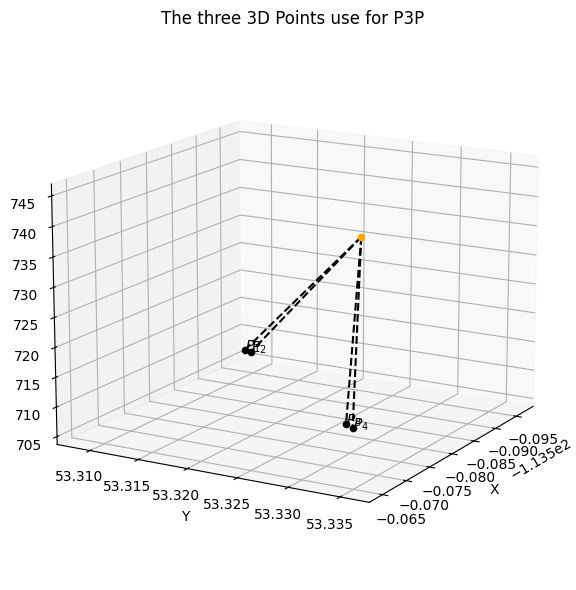

In [7]:
# Create of the 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot the camera center
ax.scatter(C[:, 0].squeeze(), C[:, 1].squeeze(), C[:, 2].squeeze(), color="orange")

# Plot the features points
for i in range(4):
    Pi = points_3D[:, i].squeeze()
    print(f"P{i+1}:", Pi)
    ax.scatter(*Pi, color="black")
    ax.text(*Pi, f"$P_{i+1}$")
    ax.plot(
        [C[:, 0].squeeze(), Pi[0]], [C[:, 1].squeeze(), Pi[1]], [C[:, 2].squeeze(), Pi[2]], "k--"
    )

# Set axis labels and limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Plot the figure
ax.set_title("The three 3D Points use for P3P")
ax.view_init(elev=15, azim=30)  # élévation de 60°, azimut de 30°
ax.grid(True)
plt.tight_layout()
plt.show()

### 6. Generate the 2D points for the P3P problem

In [8]:
from poseidon.torch import generate_synthetic_2D3Dpoints

points_2D = generate_synthetic_2D3Dpoints(R, C, A, points_3D)
points_2D_np = points_2D.squeeze(0).numpy()

print("Computed 2D points : \n", points_2D, points_2D.shape)
print("\n LARD dataset 2D points : \n", points_2D_LARD)

Computed 2D points : 
 tensor([[[ 400.9729, -326.3301],
         [ 400.9146, -326.2762],
         [ 401.8035, -326.3407],
         [ 401.7222, -326.2778]]], dtype=torch.float64) torch.Size([1, 4, 2])

 LARD dataset 2D points : 
 tensor([[[485., 454.],
         [500., 454.],
         [438., 529.],
         [590., 526.]]], dtype=torch.float64)


### 7. Compute the features vectors 

In [9]:
from poseidon.torch import get_feature_vectors

features_vectors = get_feature_vectors(points_2D[:, :3], A)
print("Features vectors:\n", features_vectors, features_vectors.shape)
# Warning: Only the first 3 points are considered

Features vectors:
 tensor([[[ 0.7704, -0.6270,  0.1153],
         [ 0.7704, -0.6270,  0.1153],
         [ 0.7711, -0.6263,  0.1151]]], dtype=torch.float64) torch.Size([1, 3, 3])


In [10]:
from poseidon.torch import compute_features_vectors, projection_all_point3D_to2D

old_points_2D = projection_all_point3D_to2D(points_3D, C, R, A)
old_features_vectors = compute_features_vectors(points_3D, C, R)
print("Old features vectors:\n", old_features_vectors, "\n", old_features_vectors.shape)

Old features vectors:
 tensor([[[-0.7704,  0.6270, -0.1153],
         [-0.7704,  0.6270, -0.1153],
         [-0.7711,  0.6263, -0.1151]]], dtype=torch.float64) 
 torch.Size([1, 3, 3])


### Test with open cv : no solution found

In [11]:
from poseidon.numpy import solve_reformat_p3p_solutions

# Convert intraseca matrix A to numpy array
A_np = A.squeeze(0).numpy()

# Apply the P3P algorithm from openCV
solutions_opencv = solve_reformat_p3p_solutions(points_3D_np[:3, :], points_2D_LARD_np[:3, :], A_np)
#print("Solutions from OpenCV P3P:\n", solutions_opencv)

nb sol =  0


### Apply the P3P algorithm in torch

In [12]:
from poseidon.torch import P3P

solutions_torch = P3P(points_3D, old_features_vectors)
print("Solutions from Poseidon P3P:\n", solutions_torch)

Solutions from Poseidon P3P:
 tensor([[[[-1.1353e+02, -5.8429e-01, -2.5183e-01,  7.7148e-01],
          [ 5.3377e+01, -6.2463e-01, -4.6736e-01, -6.2563e-01],
          [ 7.5840e+02,  5.1811e-01, -8.4744e-01,  1.1577e-01]],

         [[-1.1353e+02, -5.8429e-01, -2.5183e-01,  7.7148e-01],
          [ 5.3377e+01, -6.2463e-01, -4.6736e-01, -6.2563e-01],
          [ 7.5840e+02,  5.1811e-01, -8.4744e-01,  1.1577e-01]],

         [[-1.1356e+02, -4.8286e-01, -4.1495e-01,  7.7114e-01],
          [ 5.3336e+01, -4.5735e-01, -6.3147e-01, -6.2616e-01],
          [ 7.4417e+02,  7.4678e-01, -6.5503e-01,  1.1513e-01]],

         [[-1.1366e+02, -3.1631e-01, -5.5397e-01, -7.7010e-01],
          [ 5.3327e+01, -5.2978e-01, -5.7025e-01,  6.2781e-01],
          [ 6.7991e+02, -7.8694e-01,  6.0657e-01, -1.1310e-01]]]],
       dtype=torch.float64)


### Find the best solution 

In [13]:
from poseidon.torch import find_best_solution_P3P_batch

R_solutions, C_solutions, error = find_best_solution_P3P_batch(
    solutions_torch, points_2D, points_3D, A
)
print("\033[1m Rotation solutions (R):\033[0m\n", R_solutions)
print("R", R)
print("\033[1m Camera position solutions (C): \033[0m\n", C_solutions)
print("C", C)
print("Error :\n", error)

 Rotation solutions (R):
 tensor([[[-0.4829, -0.4149,  0.7711],
         [-0.4574, -0.6315, -0.6262],
         [ 0.7468, -0.6550,  0.1151]]], dtype=torch.float64)
R tensor([[[-0.4828, -0.4150,  0.7711],
         [-0.4573, -0.6315, -0.6262],
         [ 0.7468, -0.6550,  0.1151]]], dtype=torch.float64)
 Camera position solutions (C): 
 tensor([[[-113.5647],
         [  53.3358],
         [ 744.1748]]], dtype=torch.float64)
C tensor([[[-113.5647],
         [  53.3358],
         [ 744.1694]]], dtype=torch.float64)
Error :
 tensor([[0.0010]])
